# 6.S966 Final Project: Adapting SO(3) Equivariant Neural Networks for Molecular Dynamics Energy Minimization

To get started, download the DiffDock Repository here: https://github.com/gcorso/DiffDock and place this notebook and the data folder in the root directory

In [ ]:
import os
import yaml

from copy import deepcopy
from tempfile import NamedTemporaryFile
from argparse import Namespace
from functools import partial

In [2]:
# Paths for use throughout the computational essay
complex_names = os.listdir('md_files')
complex_name = complex_names[0]
protein_path = f'data/{complex_name}/{complex_name}_protein_processed.pdb'
predicted_ligand_path = f'data/{complex_name}/_ligand_pdbbind.sdf'
true_ligand_path = f'/data/rsg/nlp/hstark/ligbind/data/PDBBind_processed/{complex_name}/{complex_name}_ligand.sdf'

In [51]:
true_ligand_path

'/data/rsg/nlp/hstark/ligbind/data/PDBBind_processed/6hm2/6hm2_ligand.sdf'

In [48]:
complex_name

'6hm2'

## Part 1 - Background: Molecular Dynamics

Molecular Dynamics (MD) is a numerical method for simulating the behavior of atomic systems.  
In this essay, we'll start by showing you how to run an MD simulation.

### Loading and Processing Structural Files
- First we need to load and process a protein-ligand complex from the PDBBind dataset.  
- To prepare the ligand we'll use RDKit to load the file containing structural data for the ligand.
- After adding Hydrogen atoms, we convert the ligand to an OpenFF Molecule.
- To prepare the protein, we use PDBFixer load the file containing structural data for the protein and correct problems in the structure.
- We then convert the protein to an OpenMM PDBFile

In [3]:
from rdkit import Chem
import openff.toolkit as offtk

In [4]:
def prepare_ligand(ligand_path):
    """
    Given a ligand path, load the ligand, add Hydrogen atoms and convert the ligand to an OpenFF Molecule object
    * Note: If you have access to OpenEye, you should use OpenEye instead of RDKit to handle Hydrogen atoms and ionization states
    """
    # Determine the filetype of the ligand path
    filetype = os.path.splitext(ligand_path)[1]
    
    # Use RDKit to load the ligand based on the file type
    if filetype == '.sdf':
        ligand = Chem.SDMolSupplier(ligand_path)[0]
    elif filetype == '.mol':
        ligand = Chem.MolFromMolFile(ligand_path)
    elif filetype == '.mol2':
        ligand = Chem.MolFromMol2File(ligand_path)
    else:
        raise ValueError(f'File type {filetype} is not accepted.')
    
    # Add Hydrogen atoms to the ligand
    ligand = Chem.AddHs(ligand, addCoords = True)
    
    # Convert the ligand from an RDKit Molecule to an OpenFF Molecule
    ligand = offtk.Molecule.from_rdkit(ligand)
    return ligand

In [5]:
prepare_ligand(true_ligand_path)

NGLWidget()

In [6]:
from pdbfixer import PDBFixer
import openmm.app as app

In [7]:
def prepare_protein(protein_path, solvent_pH=7.0):
    """
    Given the path to a .pdb file for a protein, use PDBFixer to identify and fix incorrect structural information.
    Then add Hydrogen atoms and convert the proetin to an OpenMM PDBFile object
    """
    # Load the .pdb file into PDBFixer
    fixer = PDBFixer(filename=protein_path)
    
    # Find and fix incorrect parts of the protein structure
    fixer.findMissingResidues()
    fixer.findNonstandardResidues()
    fixer.findMissingAtoms()
    fixer.addMissingAtoms()
    fixer.replaceNonstandardResidues()
    fixer.removeHeterogens(False)
    
    # Add Hydrogen atoms
    fixer.addMissingHydrogens(solvent_pH)

    # Load the prepared protein as an OpenMM PDBFile
    with NamedTemporaryFile() as tmp:
        with open(tmp.name, 'w') as tmp_file:
            app.PDBFile.writeFile(fixer.topology, fixer.positions, file=tmp_file)
        prepared_protein = app.PDBFile(tmp.name)
    return prepared_protein

### What are MD Force Fields?
- After loading our protein and ligand, we need to paramterize our complex into a system using MD forcefield
- MD force fields are defined using analytical expressions for forces between pairs of atoms. These include
  - Harmonic forces that act on pairs or triplets of atoms as they are disturbed from an equilibrium bond length or angle
  - Period forces that act on torsion angles between sets of four atoms
  - Nonbonded forces (Coulomb and Leonard-Jones) which act between every pair of atoms
- The parameters for these forces are empirically fit to experimental data for different environments
  - For example, there is a specific equilibrium bond length and force constant for 2 Carbon atoms in a Benzene ring

### Parameterizing the System
- In this example, we use OpenMM to parameterize the protein with the Amber force field from the Amber Project
- We seperately use OpenFF to paramterize the ligand with the Sage force field from the Open Force Field
- To combine these simport parmed as pmd
ystems, we convert both of them to a ParmEd structure and join the structures together
- We then split the ParmEd structure into two files
  - The .prmtop file contains the topology of the system (connectivity and identity of atoms) as well as the parameterization of the forces
  - The .inpcrd file contains the coordinates for all atoms in the system

In [8]:
import parmed as pmd
from openff.interchange import Interchange

In [9]:
def parameterize_system(
    protein_path,
    ligand_path,
    outfilename
):
    """
    1) Paramterize the protein with the Amber Force Field
    2) Paramterize the ligand with the Sage Force Field
    3) Combine the ligand and protein systems together
    4) Save the combined system to .prmtop and .inpcrd files
    """
    # Parameterize the protein with the Amber forcefield and convert to a ParmEd structure
    print("Parameterizing Protein")
    protein = prepare_protein(protein_path, solvent_pH=7.0)
    protein_forcefield = app.ForceField('amber14-all.xml')
    protein_system = protein_forcefield.createSystem(protein.topology)
    protein_struct = pmd.openmm.load_topology(protein.topology, system=protein_system, xyz=protein.getPositions())

    # Parameterize the ligand with the OpenFF forcefield and convert to a ParmEd structure
    ligand = prepare_ligand(ligand_path)
    ligand_top = offtk.Topology.from_molecules(molecules=ligand)
    ligand_forcefield = offtk.ForceField('openff_unconstrained-2.1.0-rc.1.offxml')
    ligand_interchange = Interchange.from_smirnoff(force_field=ligand_forcefield, topology=ligand_top)
    ligand_interchange.positions = ligand.conformers[0]
    ligand_system = ligand_interchange.to_openmm()
    ligand_struct = pmd.openmm.load_topology(ligand_top.to_openmm(), system=ligand_system, xyz=ligand.conformers[0])
    
    # Combine the ligand and protein structures into a combined structure
    print("Parameterizing System")
    complex_struct = ligand_struct + protein_struct
    
    # Save the combined structure as .prmtop and .inpcrd files
    print("Saving...")
    prmtop_path, inpcrd_path = outfilename+'.prmtop', outfilename+'.inpcrd'
    with open(prmtop_path, 'w') as outfile:
        complex_struct.save(outfile, 'amber')
    prmtop = app.AmberPrmtopFile(outfilename+'.prmtop')
    with open(inpcrd_path, 'w') as outfile:
        complex_struct.save(outfile, 'rst7')
    print("Done")
    return prmtop_path, inpcrd_path

In [10]:
prmtop_path, inpcrd_path = parameterize_system(protein_path, true_ligand_path, 'test_complex')

Parameterizing Protein


/bin/bash: /data/scratch/getzn/miniconda/envs/geometric/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /data/scratch/getzn/miniconda/envs/geometric/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /data/scratch/getzn/miniconda/envs/geometric/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /data/scratch/getzn/miniconda/envs/geometric/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /data/scratch/getzn/miniconda/envs/geometric/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /data/scratch/getzn/miniconda/envs/geometric/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/data/scratch/getzn/miniconda/envs/geometric/lib/python3.10/site-packages/parmed/structure.py:1701: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(v

Parameterizing System
Saving...
Done


### Partitioning Energies
- While not traditionally done in MD Simulations, by cloning the NonBonded force from OpenMM we can seperate out the different categories of NonBonded interactions
- We define three duplicate forces for ligand-ligand, protein-protein, and ligand-protein atom pairs
- By assigning different force groups to these forces, we can seperate out the energy later
- These code snippets also help show the equations which calculate the NonBonded interaction "under the hood" of OpenMM

In [11]:
from tqdm import tqdm

from openmm import openmm
import openmm.unit as unit
import mdtraj as md

In [12]:
def clone_nonbonded_force(original_nonbonded_force):
    """
    Given a NonBonded force from OpenMM, clone the functional form of the force as a CustomNonBonded Force.
    This lets us create seperate NonBonded forces between subsets of atoms.
    """
    
    # Construct energy expression for nonbonded atoms
    energy_expression = "lj+coulomb;"

    # Lennard-Jones Interaction
    energy_expression += "lj=4*epsilon*((sigma/r)^12-(sigma/r)^6);"
    energy_expression += "sigma=0.5*(sigma1+sigma2);"
    energy_expression += "epsilon=sqrt(epsilon1*epsilon2);"

    # Coulombic Interaction
    ONE_4PI_EPS0 = 138.935456
    epsilon_solvent = original_nonbonded_force.getReactionFieldDielectric()
    r_cutoff = original_nonbonded_force.getCutoffDistance()
    k_rf = r_cutoff**(-3) * ((epsilon_solvent - 1) / (2*epsilon_solvent + 1))
    c_rf = r_cutoff**(-1) * ((3*epsilon_solvent) / (2*epsilon_solvent + 1))
    energy_expression += "coulomb=chargeprod*ONE_4PI_EPS0*(r^(-1) + k_rf*r^2-c_rf);"
    energy_expression += "chargeprod=charge1*charge2;"
    energy_expression += f"ONE_4PI_EPS0={ONE_4PI_EPS0};"
    energy_expression += f"k_rf={k_rf.value_in_unit(unit.nanometer**-3)};"
    energy_expression += f"c_rf={c_rf.value_in_unit(unit.nanometer**-1)};"

    # Create the CustomNonBondedForce from the given expression and add parameters
    custom_nonbonded_force = openmm.CustomNonbondedForce(energy_expression)
    custom_nonbonded_force.addPerParticleParameter('charge')
    custom_nonbonded_force.addPerParticleParameter('sigma')
    custom_nonbonded_force.addPerParticleParameter('epsilon')
    
    # We don't want a cutoff for the NonBonded force since we don't use explicit water atoms
    custom_nonbonded_force.setNonbondedMethod(openmm.CustomNonbondedForce.NoCutoff)
    custom_nonbonded_force.setCutoffDistance(r_cutoff)
    custom_nonbonded_force.setUseLongRangeCorrection(False)

    # Construct energy expression for bonded atoms (same as before). NonBonded forces can't be defined for bonded atoms.
    energy_expression = "lj+coulomb;"
    energy_expression += "lj=4*epsilon*((sigma/r)^12 - (sigma/r)^6);"
    energy_expression += "coulomb=ONE_4PI_EPS0*chargeprod/r;"
    energy_expression += f"ONE_4PI_EPS0={ONE_4PI_EPS0}"
    
    # Create the BondForce from the given expression and add parameters
    custom_bond_force = openmm.CustomBondForce(energy_expression)
    custom_bond_force.addPerBondParameter('chargeprod')
    custom_bond_force.addPerBondParameter('sigma')
    custom_bond_force.addPerBondParameter('epsilon')

    # Copy over parameters from the original nonbonded force
    for idx in range(original_nonbonded_force.getNumParticles()):
        custom_nonbonded_force.addParticle(original_nonbonded_force.getParticleParameters(idx))

    # Copy over exceptions and parameters from the original nonbonded force 
    for idx in range(original_nonbonded_force.getNumExceptions()):
        atom_i, atom_j, chargeprod, sigma, epsilon = original_nonbonded_force.getExceptionParameters(idx)
        custom_nonbonded_force.addExclusion(atom_i, atom_j)
        custom_bond_force.addBond(atom_i, atom_j, [chargeprod, sigma, epsilon])

    return custom_nonbonded_force, custom_bond_force

In [13]:
def md_select_indices(top, md_select):
    """
    Return the atom indices for an OpenMM topology corresponding to a particular query.
    We will use this function to identify the coordinates of the ligand and protein in the joint system
    """
    md_top = md.Topology.from_openmm(top)
    if md_select == 'ligand':
        return md_top.select('resid == 0')
    elif md_select == 'protein':
        return md_top.select('resid != 0')
    else:
        return md_top.select(md_select)

In [14]:
def partition_nonbonded_forces(system):
    """
    1) Clone the NonBonded Force for a given system
    2) Add three duplicate forces for all ligand-ligand, protein-protein, and ligand-protein atoms pairs
    """
    # Get the original nonbonded force
    for force in system.getForces():
        if isinstance(force, openmm.NonbondedForce):    
            original_nonbonded_force = force
    
    # Clone the nonbonded force
    custom_nonbonded_force, custom_bond_force = clone_nonbonded_force(original_nonbonded_force)

    # Add the custom bond force
    system.addForce(custom_bond_force)
    custom_bond_force.setForceGroup(0)

    # Get the ligand and protein atom indices
    lig_idxs = md_select_indices(prmtop.topology, 'ligand')
    prot_idxs = md_select_indices(prmtop.topology, 'protein')

    # Add the cloned nonbonded force for ligand-ligand interactions
    lig_lig_nonbonded_force = deepcopy(custom_nonbonded_force)
    lig_lig_nonbonded_force.addInteractionGroup(lig_idxs, lig_idxs)
    system.addForce(lig_lig_nonbonded_force)
    lig_lig_nonbonded_force.setForceGroup(1)

    # Add the cloned nonbonded force for protein-protein interactions
    prot_prot_nonbonded_force = deepcopy(custom_nonbonded_force)
    prot_prot_nonbonded_force.addInteractionGroup(prot_idxs, prot_idxs)
    system.addForce(prot_prot_nonbonded_force)
    prot_prot_nonbonded_force.setForceGroup(2)
    
    # Add the cloned nonbonded force for ligand-protein interactions
    lig_prot_nonbonded_force = deepcopy(custom_nonbonded_force)
    lig_prot_nonbonded_force.addInteractionGroup(lig_idxs, prot_idxs)
    system.addForce(lig_prot_nonbonded_force)
    lig_prot_nonbonded_force.setForceGroup(3)
    
    #Remove the original nonbonded force
    for i, force in enumerate(system.getForces()):
        if isinstance(force, openmm.NonbondedForce): 
            system.removeForce(i)

In [15]:
# Load the saved .prmtop file
prmtop = app.AmberPrmtopFile(prmtop_path)

# Create a system from the .prmtop file
system = prmtop.createSystem(
    nonbondedMethod=app.NoCutoff, # Calculate the NonBonded force for all pairs of atoms
    implicitSolvent=app.HCT, # We account for solvent "implicitly" by simulating a dielectric over the surface area of the complex
    constraints=app.HBonds # We fix the length of Hydrogen bonds as a constraint
)

# Partition the nonbonded forces as defined above
partition_nonbonded_forces(system)

/data/scratch/getzn/miniconda/envs/geometric/lib/python3.10/site-packages/openmm/app/internal/amber_file_parser.py:1102: UserWarning: Non-optimal GB parameters detected for GB model HCT
  warnings.warn(


### Constructing a Simulation
- Now that we have a parameterized system, we can run an MD Simulation on our system
- To construct a simulation, we define a Langevin integrator which at each time step, calculates forces per atom and integrates the system while adding noise proportional to the temperature
- To ensure that the simulation doesn't diverge, we first "minimize" the system by "relaxing" its constraints so that we start from an energetically reasonable state

In [16]:
def construct_simulation(system, topology, positions, minimize=True):
    """
    Construct a simulation from a system, topology and atomic coordinates
    """
    # Define the integrator for the simulation
    integrator = openmm.LangevinMiddleIntegrator(
            300*unit.kelvin, # Temperature
            1/unit.picosecond, # Friction
            0.002*unit.picoseconds # Step size
    )
    
    # Create the simulation from the topology, system and integrator
    simulation = app.Simulation(topology, system, integrator)
    
    # Set the coordinates of the system
    simulation.context.setPositions(positions)
    
    # Relax the system to minimize the energy
    if minimize:
        simulation.minimizeEnergy()
    return simulation

In [17]:
# Get atomic coordinates from the .inpcrd file
inpcrd = app.AmberInpcrdFile(inpcrd_path)
complex_positions = inpcrd.getPositions(asNumpy=True)

# Construct the simulation
simulation = construct_simulation(system, prmtop.topology, complex_positions)

### Running a Simulation
- To run a simulation, we'll iteratively progress the system by intervals of 10 steps
- Then for each iteration, we'll save the energy and the positions
- Finally, we'll save the system trajectory using MDTraj so you can visualize it in a Desktop application like PyMol

In [18]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Initialize arrays for simulation data
traj_positions = []
traj_total_energies = []
traj_energy_decomps = []

# Start with buffer steps
simulation.step(500)

# Simulation loop
for i in tqdm(range(250)):
    # Get the total energy and atomic positions of the system
    state = simulation.context.getState(getEnergy=True, getPositions=True)
    total_energy = state.getPotentialEnergy()._value
    positions = state.getPositions(asNumpy=True)
    
    # Get the energy for each force group
    energy_decomp = []
    for group in range(4):
        state = simulation.context.getState(getEnergy=True, groups={group})
        energy_decomp.append(state.getPotentialEnergy()._value)
        
    # Append the simulation data
    traj_positions.append(positions)
    traj_total_energies.append(total_energy)
    traj_energy_decomps.append(energy_decomp)

    # Progress the simulation by 10 steps
    simulation.step(10)

In [31]:
abs_log_transform = lambda x: np.sign(x) * np.log(np.abs(x)) # So we can plot negative and positive energies in log scale
xs = (np.arange(250) + 100) * 10 * 0.002 # Timesteps

In [ ]:
ys = abs_log_transform(np.array(traj_total_energies))

plt.plot(xs, ys)
plt.title('Total Energy over the Simulation', y = 1.05)
plt.ylabel('(Signed) Log Energy (kJ / Mol)')
plt.xlabel('Time (ps)')
plt.show()

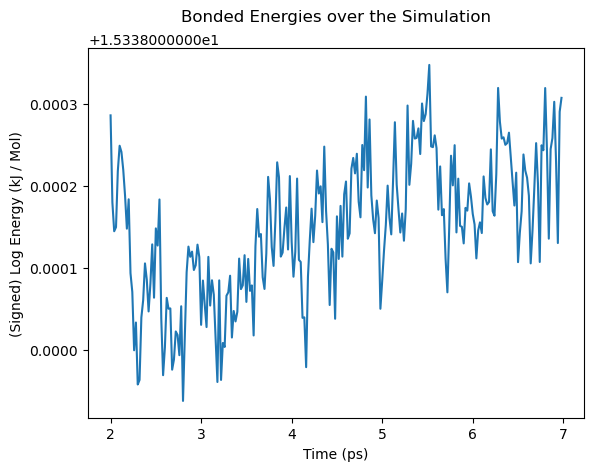

In [150]:
ys = abs_log_transform(np.array((traj_energy_decomps))[:,0])

plt.plot(xs, ys,)
plt.title('Bonded Energies over the Simulation', y=1.05)
plt.ylabel('(Signed) Log Energy (kJ / Mol)')
plt.xlabel('Time (ps)')
plt.show()

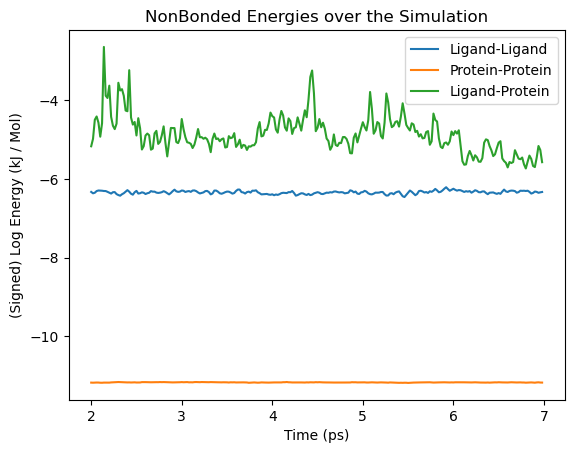

In [147]:
ys = abs_log_transform(np.array((traj_energy_decomps))[:,1:])

plt.plot(xs, ys, label=['Ligand-Ligand','Protein-Protein','Ligand-Protein'])
plt.title('NonBonded Energies over the Simulation')
plt.ylabel('(Signed) Log Energy (kJ / Mol)')
plt.xlabel('Time (ps)')
plt.legend()
plt.show()

In [152]:
# Convert the trajectory positions to an MDTraj Trajectory and save the file
md_top = md.Topology.from_openmm(simulation.topology)
traj = md.Trajectory(np.stack(traj_positions), md_top)
traj.save('md_simulation.pdb')

## Part 2: Even more Background - DiffDock

### Intro to DiffDock
- DiffDock is an SO(3) equivariant diffusion model for molecular docking - 
the process of finding the location and pose in the binding pocket of a protein where a ligand binds to
- The DiffDock model learns a diffusion process over three degrees of freedom: translation, rotation, and torsion angles 
- In our experiments we restrict our attention to torsion angles to simplify the problem
- The DiffDock (score) model was trained by starting from PDBBind crystal structures, adding noise to all degrees of freedom and optimizing the denoising score matching objective
- Lets start by loading the DiffDock score model

In [19]:
import torch
from torch_geometric.data import Batch, HeteroData

from rdkit.Geometry import Point3D

# Load utils from the DiffDock repository
from utils.diffusion_utils import t_to_sigma as t_to_sigma_compl, get_t_schedule, modify_conformer, set_time
from utils.torsion import modify_conformer_torsion_angles
from utils.utils import get_symmetry_rmsd, get_model
from utils.sampling import randomize_position
from utils.diffusion_utils import t_to_sigma as t_to_sigma_compl, get_t_schedule, set_time
from datasets.conformer_matching import get_torsion_angles, OptimizeConformer
from datasets.process_mols import read_molecule, get_rec_graph, \
    get_lig_graph_with_matching, extract_receptor_structure, parse_receptor, parse_pdb_from_path, \
    generate_conformer

In [20]:
# Paths for the DiffDock Score Model used in the DiffDock paper
model_dir = 'workdir/paper_score_model'
model_ckpt = 'best_ema_inference_epoch_model.pt'
device = torch.device('cuda:1')

# Load the args for the score model
with open(f'{model_dir}/model_parameters.yml') as f:
    score_model_args = Namespace(**yaml.full_load(f))
state_dict = torch.load(f'{model_dir}/{model_ckpt}', map_location=torch.device('cpu'))
t_to_sigma = partial(t_to_sigma_compl, args=score_model_args)

# Construct the score model
model = get_model(score_model_args, device, t_to_sigma=t_to_sigma, no_parallel=True)
model.load_state_dict(state_dict, strict=True)
model = model.to(device)
model.eval()

# Get the noise level at the chosen timestep (t = 0.05)
tor_schedule = get_t_schedule(inference_steps=20) # The torsion schedule governs how noise is removed over the trajectory
t_tor = tor_schedule[15] # We only consider a fixed timestep for this experiment
tr_sigma, rot_sigma, tor_sigma = t_to_sigma(0, 0, t_tor) # Here we convert the time to noise values
dt_tor = tor_schedule[15] - tor_schedule[16] # The change in time is used for a step size
tor_g = tor_sigma * torch.sqrt(torch.tensor(2 * np.log(score_model_args.tor_sigma_max / score_model_args.tor_sigma_min))) # This value is used to scale the amount of noise

/data/scratch/getzn/miniconda/envs/geometric/lib/python3.10/site-packages/torch/jit/_check.py:181: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


### Loading Data
- DiffDock represents complexes as a heterogenous graph consisting of a protein scaffold and a ligand
- The data structure specifies the identity and connectivity of atoms as well as which ligand bonds are rotatable
- Protein embeddings are computed using the ESM language model from Meta
- Here we start by loading the final pose of a DiffDock trajectory for an inference run that we previously conducted

In [21]:
def construct_graph(
    complex_name, ligand_path, protein_path, 
    c_alpha_max_neighbors=10,
    remove_hs=False,
    all_atoms=False,
    atom_radius=5,
    atom_max_neighbors=None,
    receptor_radius=30, 
    lm_embeddings_map=None, 
):
    """
    Given a ligand path and a protein path, construct a PyTorch Geometric HeteroGraph to represent the complex.
    * Code taken and altered from the DiffDock Repository
    """
    graph = HeteroData()
    # Fetch the computed LM embedding
    lm_embedding = lm_embeddings_map[complex_name] if lm_embeddings_map is not None else None

    # Parse the ligand from the top ranked pose sdf file
    mol = read_molecule(ligand_path, sanitize=True)

    get_lig_graph_with_matching(mol, graph, popsize=None, maxiter=None, matching=False,
                                keep_original=False, num_conformers=1, remove_hs=remove_hs)

    # Parse the receptor from the ESMFold pdb file
    rec_model = parse_pdb_from_path(protein_path)
    rec, rec_coords, c_alpha_coords, n_coords, c_coords, lm_embeddings = extract_receptor_structure(rec_model, mol, lm_embedding_chains=[lm_embedding])

    get_rec_graph(rec, rec_coords, c_alpha_coords, n_coords, c_coords, graph,
                  rec_radius=receptor_radius,
                  c_alpha_max_neighbors=c_alpha_max_neighbors, all_atoms=all_atoms,
                  atom_radius=atom_radius, atom_max_neighbors=atom_max_neighbors,
                  remove_hs=remove_hs, lm_embeddings=lm_embeddings)

    # Verify that the LM embedding is of propper length
    if lm_embeddings is not None and len(c_alpha_coords) != len(lm_embeddings):
        print(f'LM embeddings for protein {protein_id} did not have the right length for the protein. Skipping {protein_id}.')
        if progress_bar is not None:
            progress_bar.update(1)
        return

    # Set the origin to the protein center
    protein_center = torch.mean(graph['receptor'].pos, dim=0, keepdim=True)
    graph['receptor'].pos -= protein_center
    graph['ligand'].pos -= protein_center
    if all_atoms:
        graph['atom'].pos -= protein_center
    graph['original_center'] = protein_center

    # Fix rotatable bonds mask for single graph batch
    graph['ligand'].mask_rotate = [graph['ligand'].mask_rotate]

    return graph

In [22]:
# Load the LM embeddings
lm_embeddings_by_complex = {key.split('_')[0]: vals for key, vals in torch.load('esm_embeddings_pdbbind_val_unseen.pt').items()}

# Construct a graph from the ligand path of a previous DiffDock inference run
graph = construct_graph(complex_name, predicted_ligand_path, protein_path, lm_embeddings_map=lm_embeddings_by_complex, remove_hs=True)

### Physical Significance of the Score Model
- Since MD force fields are calculated for atomic distances, angles, and torsions, the forces do not change under SO(3) transfromations, - These means that MD methods are invariant under SO(3) transformations which makes it an interesting prospect to investigate how we can combine MD methods with SO(3) equivariant ML models like DiffDock
- Moreover, unlike most diffusion models, the score model of DiffDock is physically significant at low noise levels
  - Since the distribution of poses is guided by the Boltzman distribution, the score predicted by DiffDock at low noise levels should approximate the score of the Boltzman distribution
  - The score of the Boltzman distribution is simply the force on each atom so at low noise levels, DiffDock should approximate forces
  - This creates a beautiful parallel between MD simulations and the diffusion process defined by DiffDock

## Experiment: Using DiffDock for Energy Minimization

### Motivation
- We wanted to explore the interplay between invariant MD methods and equivariant ML models (DiffDock) by seeing if we could use DiffDock to minimize the energy of a protein-ligand complex as defined by an MD force field
- Starting from the final pose of a DiffDock trajectory, we wanted to see how low we could get the energy of pose (while only changing torsion angles)
- This is especially interesting because MD simulations are impoverished in constraints and there is no method native to MD to only relax the torsion angles of the pose
- Specifically, we approach the problem by running an MCMC simulation where we use DiffDock as the proposal distribution and the MD energy function as the log of the target distribution

### Setup
- Since DiffDock trajectories don't include Hydrogen atoms, we start by defining functions to facilitate the interchange of atomic coordinates between DiffDock frames and MD simulations
- We also define a function that returns the MD energy decomposition for a given ligand pose
- We start by defining RDKit molecules for the true pose and the final pose predicted by DiffDock
- We also calculate the RMSD of the predicted pose as well as the minimized and unminimized energies

In [23]:
def modify_ligand_positions(ligand, positions):
    """
    Given an RDKit ligand and a set of atomic positions, return a copy of the ligand with the updated atomic positions
    """
    ligand = deepcopy(ligand)
    conf = ligand.GetConformer()
    for i in range(ligand.GetNumAtoms()):
        atom_coords = [float(coord) for coord in positions._value[i]]
        conf.SetAtomPosition(i, Point3D(*atom_coords))
    return ligand

In [24]:
def score_energy_decomposition(system, topology, positions, minimize=False):
    """
    Given an OpenMM system, topology and set of positions, return the corresponding total energy and energy decomposition.
    """
    # Define the integrator
    integrator = openmm.LangevinMiddleIntegrator(
        300*unit.kelvin, # Temperature
        1/unit.picosecond, # Friction
        0.002*unit.picoseconds # Timestep
    )
    
    # Construct the simulation and set atomic positions
    simulation = app.Simulation(topology, system, integrator)
    simulation.context.setPositions(positions)
    
    # If specified, minimize the system
    if minimize:
        simulation.minimizeEnergy()
    
    # Get the total energy of the system
    state = simulation.context.getState(getEnergy=True)
    total_energy = state.getPotentialEnergy()._value
    
    # Get the energy decomposition of the system
    energy_decomp = []
    for group in range(4):
        state = simulation.context.getState(getEnergy=True, groups={group})
        energy_decomp.append(state.getPotentialEnergy()._value)
    return total_energy, energy_decomp

In [25]:
# Load the true ligand from PDBBind and add Hydrogen atoms
true_ligand_noh = Chem.SDMolSupplier(true_ligand_path)[0]
true_ligand_noh_positions = true_ligand_noh.GetConformer().GetPositions()
true_ligand = Chem.rdmolops.AddHs(true_ligand_noh, addCoords=True)
true_ligand_positions = true_ligand.GetConformer().GetPositions()

# Load the DiffDock final ligand pose and add Hydrogen atoms
ligand_noh_positions = np.array(graph['ligand'].pos)
ligand_noh_positions += np.array(graph['original_center'])
ligand_noh_positions = unit.Quantity(ligand_noh_positions, unit.angstrom)
ligand_noh = modify_ligand_positions(true_ligand_noh, ligand_noh_positions)
ligand = Chem.rdmolops.AddHs(ligand_noh, addCoords=True)

# Update the atomic coordinates of the complex based on the DiffDock final ligand pose
ligand_positions = ligand.GetConformer().GetPositions()
ligand_positions = unit.Quantity(ligand_positions, unit.angstrom)
complex_positions[:ligand_positions.shape[0]] = ligand_positions

# Get the unminimized and minimized energy of the complex
total_energy, energy_decomp = score_energy_decomposition(system, prmtop.topology, complex_positions)
minimized_total_energy, minimized_energy_decomp = score_energy_decomposition(system, prmtop.topology, complex_positions, minimize=True)

# Get the RMSD of the DiffDock final ligand pose from the true pose
rmsd = get_symmetry_rmsd(true_ligand_noh, true_ligand_noh_positions, ligand_noh_positions._value)

### The MCMC Method
- We then use an MCMC method through the following procedure for each MCMC step
- For the proposal distribution
  1) Given a pose, we use the DiffDock score model to calculate the torsional score
  2) By combining the score with a normal noise vector, we calculate the torsional adjustement
  3) We generate a candidate pose by applying the torsional adjustment
  4) The DiffDock score model is then used to calculate the the torsional score of the candidate pose
  5) This lets us determine which noise vector would induce a step from the candidate pose to the original
  6) Using a Gaussian PDF we can determine the probability of the forwards and reverse transition
- For the target distribution
  1) We add Hydrogen atoms to the initial and candidate poses
  2) Then using the coordinates for each pose, we calculate the corresponding MD energy decomposition
  3) We treat these energy values as the log of the target distribution
- We then compute the acceptance factor (probability of accepting the candidate pose)

In [27]:
from scipy.stats import norm as gaussian

In [29]:
# Load the graph for the DiffDock Prediction

# Note: The sampling aspects of this code are modified from the DiffDock repository

# Initialize arrays to track quantities of interest
total_energies = [total_energy]
energy_decomps = [energy_decomp]
traj_complex_positions = [complex_positions]
rmsds = [rmsd]

for it in tqdm(range(250)):
    # Create a batch with the single graph and set the time
    batch = Batch.from_data_list([graph])
    batch = batch.to(device)
    set_time(batch, 0, 0, t_tor, 1, score_model_args.all_atoms, device)
    
    # Calculate the score of the pose
    with torch.no_grad():
        tr_score, rot_score, tor_score = model(batch)
    
    # We don't change the rototranslation
    tr_perturb = torch.zeros((1, 3))
    rot_perturb = torch.zeros((1, 3))
    
    # Calculate the torsional adjustment by taking a (weighted) step in the direction of the score and adding noise
    tor_z = torch.normal(mean=0, std=1, size=tor_score.shape)
    tor_perturb = (tor_g ** 2 * dt_tor * tor_score.cpu() + tor_g * np.sqrt(dt_tor) * tor_z).numpy()
    
    # Modify the graph with the torsion adjustment and create a batch for the new graph (this is the pose candidate)
    new_graph = modify_conformer(deepcopy(graph), tr_perturb, rot_perturb.squeeze(0), tor_perturb)
    new_batch = Batch.from_data_list([new_graph])
    new_batch = new_batch.to(device)
    set_time(new_batch, 0, 0, t_tor, 1, score_model_args.all_atoms, device)
    
    # Calculate the score of the candidate pose
    with torch.no_grad():
        new_tr_score, new_rot_score, new_tor_score = model(new_batch)
    
    # Generate an RDKit Molecule with coordinates from the candidate pose and add Hydrogens
    new_ligand_noh_positions = np.array(new_graph['ligand'].pos)
    new_ligand_noh_positions += np.array(new_graph['original_center'])
    new_ligand_noh_positions = unit.Quantity(new_ligand_noh_positions, unit.angstrom)
    new_ligand_noh = modify_ligand_positions(true_ligand_noh, new_ligand_noh_positions)
    new_ligand = Chem.rdmolops.AddHs(new_ligand_noh, addCoords=True)
    
    # Update a new set of positions for the complex using the coordinates of the candidate pose
    new_ligand_positions = new_ligand.GetConformer().GetPositions()
    new_ligand_positions = unit.Quantity(new_ligand_positions, unit.angstrom)
    new_complex_positions = deepcopy(complex_positions)
    new_complex_positions[:new_ligand_positions.shape[0]] = new_ligand_positions
    
    # Calculate the RMSD between the true ligand positions and the candidate pose
    new_rmsd = get_symmetry_rmsd(true_ligand_noh, true_ligand_noh_positions, new_ligand_noh_positions._value)
    
    # Calculate the unminimized energy of the complex with the candidate pose
    new_total_energy, new_energy_decomp = score_energy_decomposition(system, prmtop.topology, new_complex_positions)
    
    # Determine what noise vector would facilitate a step from the candidate pose to the original
    reverse_tor_pertrub = -1 * tor_perturb
    reverse_tor_z = (reverse_tor_pertrub - (tor_g ** 2 * dt_tor * tor_score.cpu()).numpy()) / (tor_g * np.sqrt(dt_tor))
    
    # Use the noise vectors for both transitions to calculate the log probability of making the transition
    forwards_log_prob = np.log(np.prod(gaussian.pdf(tor_z)))
    reverse_log_prob = np.log(np.prod(gaussian.pdf(reverse_tor_z)))
    
    # Calculate an acceptance factor
    a = min(np.exp((reverse_log_prob - forwards_log_prob) - (new_total_energy - total_energy)), 1)
    
    # Accept the candidate pose with probability a
    if np.random.uniform() <= a:
        graph = new_graph
        total_energy = new_total_energy
        energy_decomp = new_energy_decomp
        complex_positions = new_complex_positions
        rmsd = new_rmsd 

    total_energies.append(total_energy)
    traj_complex_positions.append(complex_positions)
    energy_decomps.append(energy_decomp)
    rmsds.append(rmsd)

  2%|▋                                          | 4/250 [00:07<08:12,  2.00s/it]/tmp/ipykernel_2901290/1410806431.py:67: RuntimeWarning: overflow encountered in exp
  a = min(np.exp((reverse_log_prob - forwards_log_prob) - (new_total_energy - total_energy)), 1)
100%|█████████████████████████████████████████| 250/250 [07:30<00:00,  1.80s/it]


## Part 4: Results and Conclusions

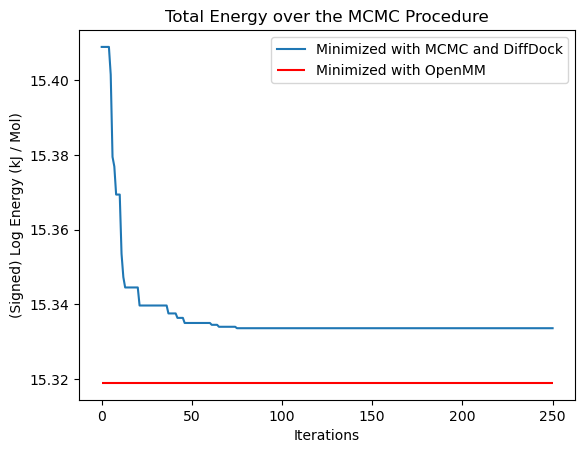

In [44]:
plt.plot(abs_log_transform(np.array(total_energies)), label='Minimized with MCMC and DiffDock')
plt.hlines(y=abs_log_transform(minimized_total_energy), xmin=0, xmax=250, color='red', label='Minimized with OpenMM')
plt.title('Total Energy over the MCMC Procedure')
plt.ylabel('(Signed) Log Energy (kJ / Mol)')
plt.xlabel('Iterations')
plt.legend()
plt.show()

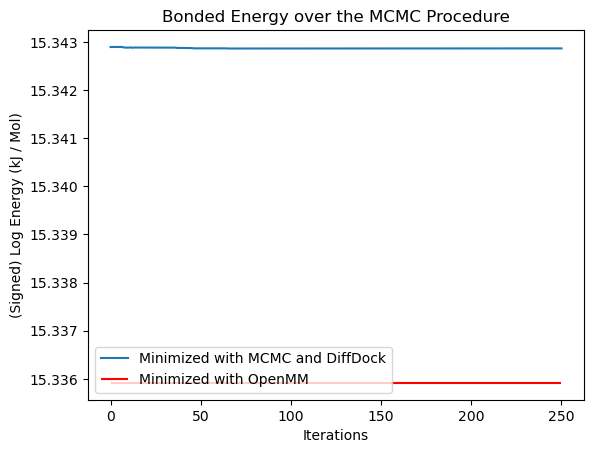

In [45]:
plt.plot(abs_log_transform(np.stack(energy_decomps)[:, 0]), label='Minimized with MCMC and DiffDock')
plt.hlines(y=abs_log_transform(minimized_energy_decomp[0]), xmin=0, xmax=250, color='red', label='Minimized with OpenMM')
plt.title('Bonded Energy over the MCMC Procedure')
plt.ylabel('(Signed) Log Energy (kJ / Mol)')
plt.xlabel('Iterations')
plt.legend()
plt.show()

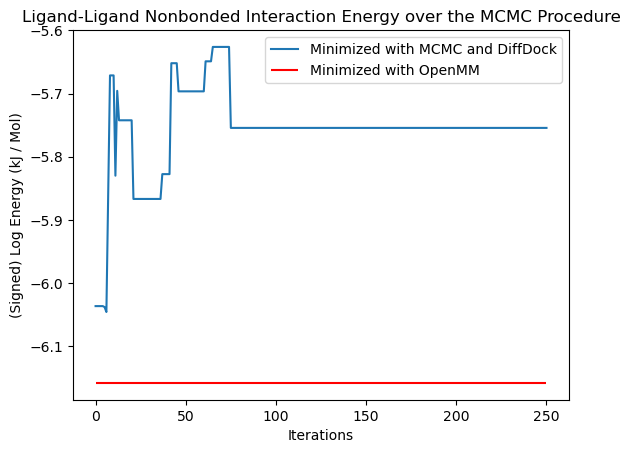

In [46]:
plt.plot(abs_log_transform(np.stack(energy_decomps)[:, 1]), label='Minimized with MCMC and DiffDock')
plt.hlines(y=abs_log_transform(minimized_energy_decomp[1]), xmin=0, xmax=250, color='red', label='Minimized with OpenMM')
plt.title('Ligand-Ligand Nonbonded Interaction Energy over the MCMC Procedure')
plt.ylabel('(Signed) Log Energy (kJ / Mol)')
plt.xlabel('Iterations')
plt.legend()
plt.show()

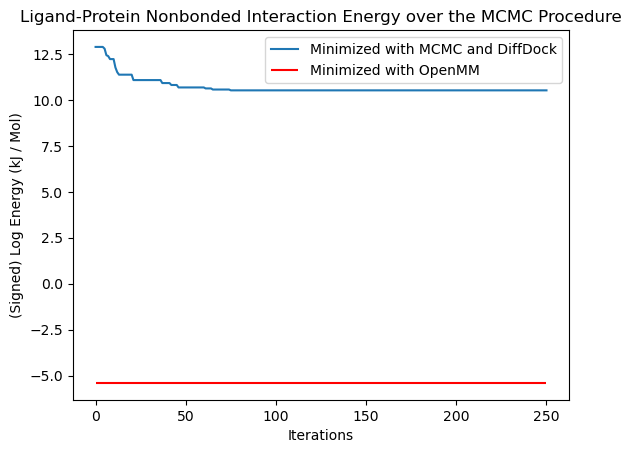

In [47]:
plt.plot(abs_log_transform(np.stack(energy_decomps)[:, 3]), label='Minimized with MCMC and DiffDock')
plt.hlines(y=abs_log_transform(minimized_energy_decomp[3]), xmin=0, xmax=250, color='red', label='Minimized with OpenMM')
plt.title('Ligand-Protein Nonbonded Interaction Energy over the MCMC Procedure')
plt.ylabel('(Signed) Log Energy (kJ / Mol)')
plt.xlabel('Iterations')
plt.legend()
plt.show()

- Here we can see that the total energy of the system decreases over time and that most of this change is due to the ligand-protein nonbonded interaction energy
- This initial approach is pretty simple but it shows that DiffDock could be in theory used to define the proposal distribution for an arbitrary function
- Lots of work would still need to be done to further improve performance but the initial result provides insight into how invariant MD methods can be combined with equivariant ML methods
- Specifically, this indicates that at low noise levels, the DiffDock score model can behave similar to the force field which is used to minimize protein-ligand systems

## Part 5: Next Steps
- The next steps we would like to test involve first trying this approach for other complexes to validate our findings
- We would also like to try more advanced sampling methods like simulated annealing or annealed importance sampling and scale down the noise level over time
- The most exciting next step would be using models like DiffDock to evaluate how a specific mechanistically important conformational motif (ie the motion of a specific residue or sidechain) affects the energy of a complex
- Traditional MD methods can't handle specific degrees of freedom since the combination of required constraints would result in the evaluation of a singular matrix
- However, if we repeated this experiment with a DiffDock-like model with different degrees of freedom, we would be able to see if we can use such a network to perform MD minimization and later simulations over arbitrary degrees of freedom / constraints
- Moreover, we would want to see if this can inform how an arbitrary motif factors into the energetics of the complex

## Part 6: Works Cited and Related Works
- Corso, G., Stärk, H., Jing, B., Barzilay, R., & Jaakkola, T. (2022). Diffdock: Diffusion steps, twists, and turns for molecular docking. arXiv preprint arXiv:2210.01776.
- Jing, B., Corso, G., Chang, J., Barzilay, R., & Jaakkola, T. (2022). Torsional diffusion for molecular conformer generation. arXiv preprint arXiv:2206.01729.
- Du, Y., Durkan, C., Strudel, R., Tenenbaum, J. B., Dieleman, S., Fergus, R., ... & Grathwohl, W. (2023). Reduce, Reuse, Recycle: Compositional Generation with Energy-Based Diffusion Models and MCMC. arXiv preprint arXiv:2302.11552
- Boothroyd, S., Behara, P., Madin, O., Hahn, D., Jang, H., Gapsys, V., . . . Mobley, D. (2022). Development and Benchmarking of Open --Force Field 2.0.0 — the Sage Small Molecule Force Field. ChemRxiv. doi:10.26434/chemrxiv-2022-n2z1c This content is a preprint and has not been peer-reviewed.
- Geiger, M., & Smidt, T. (2022). e3nn: Euclidean neural networks. arXiv preprint arXiv:2207.09453.